# with Eve

In [1]:
import numpy as np 
import qiskit_ibm_runtime as ibmruntime
import qiskit_aer as aer
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
from qiskit.primitives import BackendSamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import transpile
from qiskit.circuit import ClassicalRegister , QuantumRegister , QuantumCircuit 
from qiskit_ibm_runtime import SamplerOptions
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Alice's Encoding Message

In [2]:
# create message 
def create_massage (message_length : int):
    message_list = np.random.randint(0,2,size = message_length)
    return message_list

[1 1 0 1 0] [0 1 1 0 0]


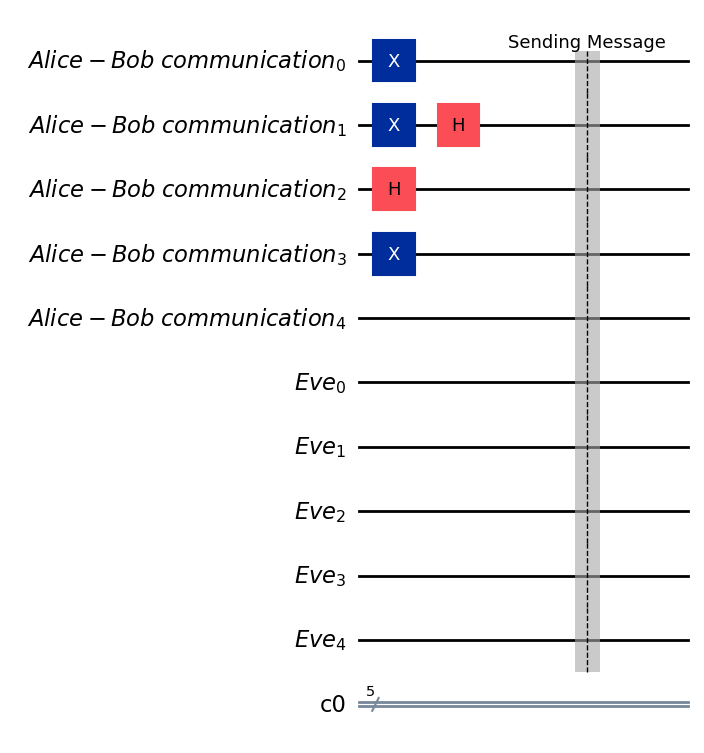

In [3]:
# encod message in a randomly chosen basis

def encoded_message(message_length,message_list):
    random_basis_list = np.random.randint(0 , 2 , size = message_length) # 0 : Z basis 1 : X basis
    encoded_quantum_circuit  = QuantumRegister(size = message_length , name = 'Alice-Bob communication')
    Eve_measure              = QuantumRegister(message_length , name = 'Eve')
    Measurement              = ClassicalRegister(message_length)
    encoded_quantum_circuit  = QuantumCircuit(encoded_quantum_circuit , Eve_measure , Measurement)
    for message , basis , bits in zip(message_list , random_basis_list, np.arange(message_length)):
        if basis == 0 and message == 0:
            pass
        elif basis == 0 and message == 1 :
            encoded_quantum_circuit.x(bits)
        elif basis == 1 and message == 0 :
            encoded_quantum_circuit.h(bits)
        elif basis == 1 and message == 1 :
            encoded_quantum_circuit.x(bits)
            encoded_quantum_circuit.h(bits)
    encoded_quantum_circuit.barrier(label= 'Sending Message')
    return encoded_quantum_circuit,random_basis_list



test_message_length = 5 
test_message = create_massage(test_message_length)
QC_test,basis_test = encoded_message(test_message_length,test_message)
print (test_message,basis_test)
QC_test.draw('mpl')

        

# Eve's inception

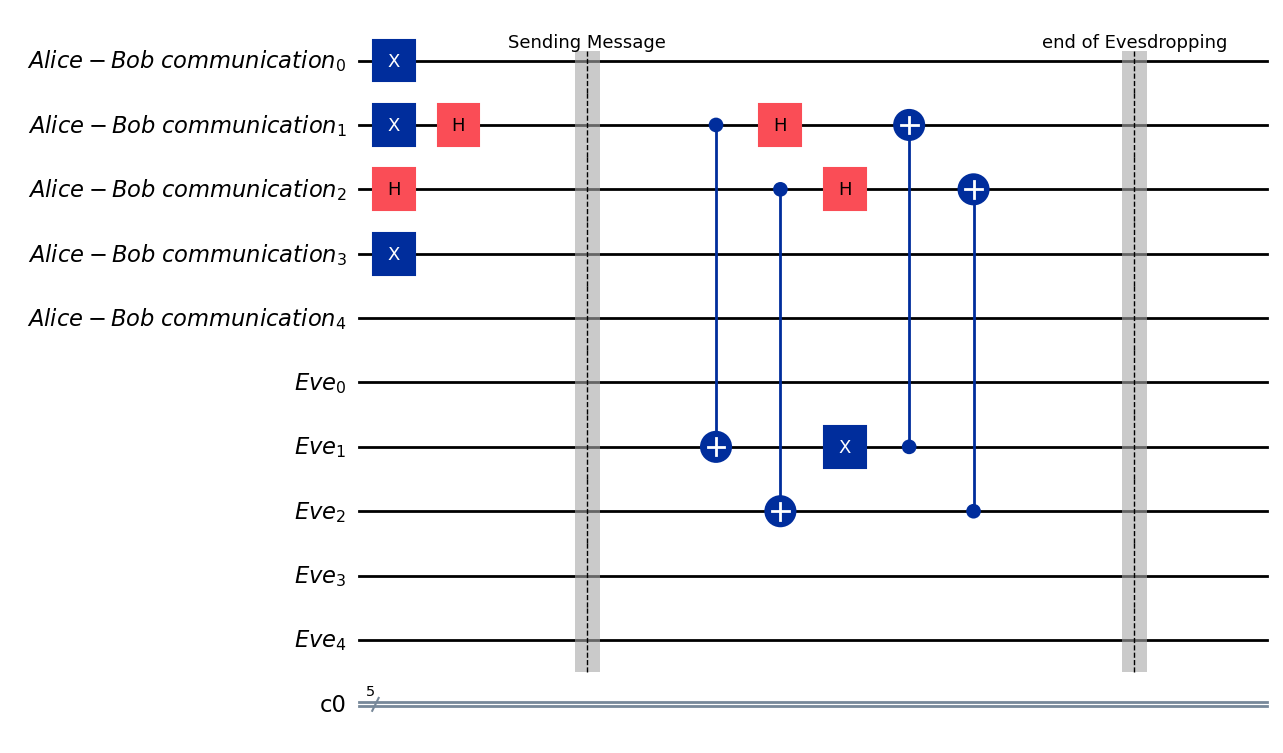

In [4]:
# Measure the message and resending the meassage to Bob
# Assume Eve use Z basis to do the measurement
def Eve_measurement(message_list , alice_basis_list , message_length , alice_sending_quantum_circuit : QuantumCircuit):
    for evesdropping , basis , bits in zip (message_list , alice_basis_list , np.arange(message_length)):
        if basis == 0 :
            pass
        elif evesdropping == 0 :
            alice_sending_quantum_circuit.cx(bits ,bits + message_length)
            alice_sending_quantum_circuit.h(bits)
            alice_sending_quantum_circuit.cx(bits + message_length , bits)
        elif evesdropping == 1 :
            alice_sending_quantum_circuit.cx(bits , bits + message_length)
            alice_sending_quantum_circuit.h(bits)
            alice_sending_quantum_circuit.x(bits + message_length)
            alice_sending_quantum_circuit.cx(bits + message_length , bits)
    return alice_sending_quantum_circuit 
    

circuit = Eve_measurement(test_message,basis_test,test_message_length,QC_test)
circuit.barrier(label = 'end of Evesdropping')
circuit.draw('mpl')


        



# Bob Measuring

# Looking for Correlations

[1 0 1 0 1]


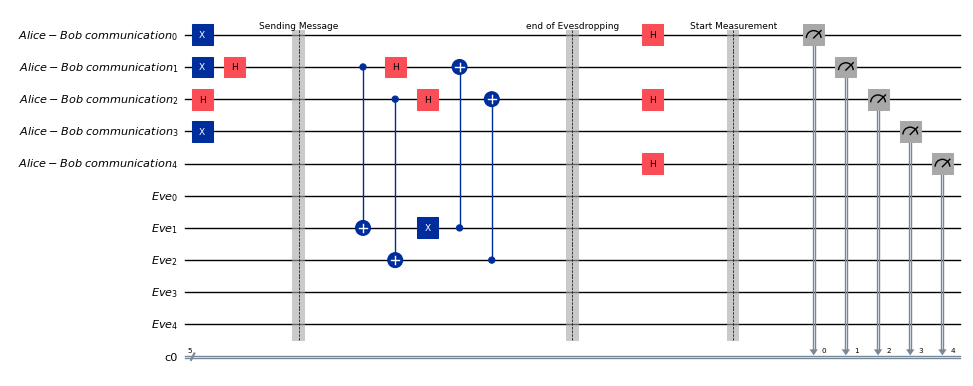

In [5]:
# Mesure the qubits through randomly choose basis
# 0 : Z basis 
# 1 : X basis

def create_measure_basis(message_length):
    random_measure_basis = np.random.randint(message_length)
    return random_measure_basis

def do_mesurement(message_length : int , measure_basis_list , message_quantum_circuit : QuantumCircuit):
    for basis , bits in zip(measure_basis_list , np.arange(message_length)) :
        if basis == 0 :
            pass
        elif basis == 1 :
            message_quantum_circuit.h(bits)
    message_quantum_circuit.barrier(label= 'Start Measurement')
    message_quantum_circuit.measure(range(message_length),range(message_length))
    return message_quantum_circuit

test_measure_basis = create_massage(test_message_length)
print (test_measure_basis)
measurement_quantum_circuit = do_mesurement(test_message_length, test_measure_basis ,circuit)
measurement_quantum_circuit.draw('mpl',scale=0.5)



# Run on Classical Simulator

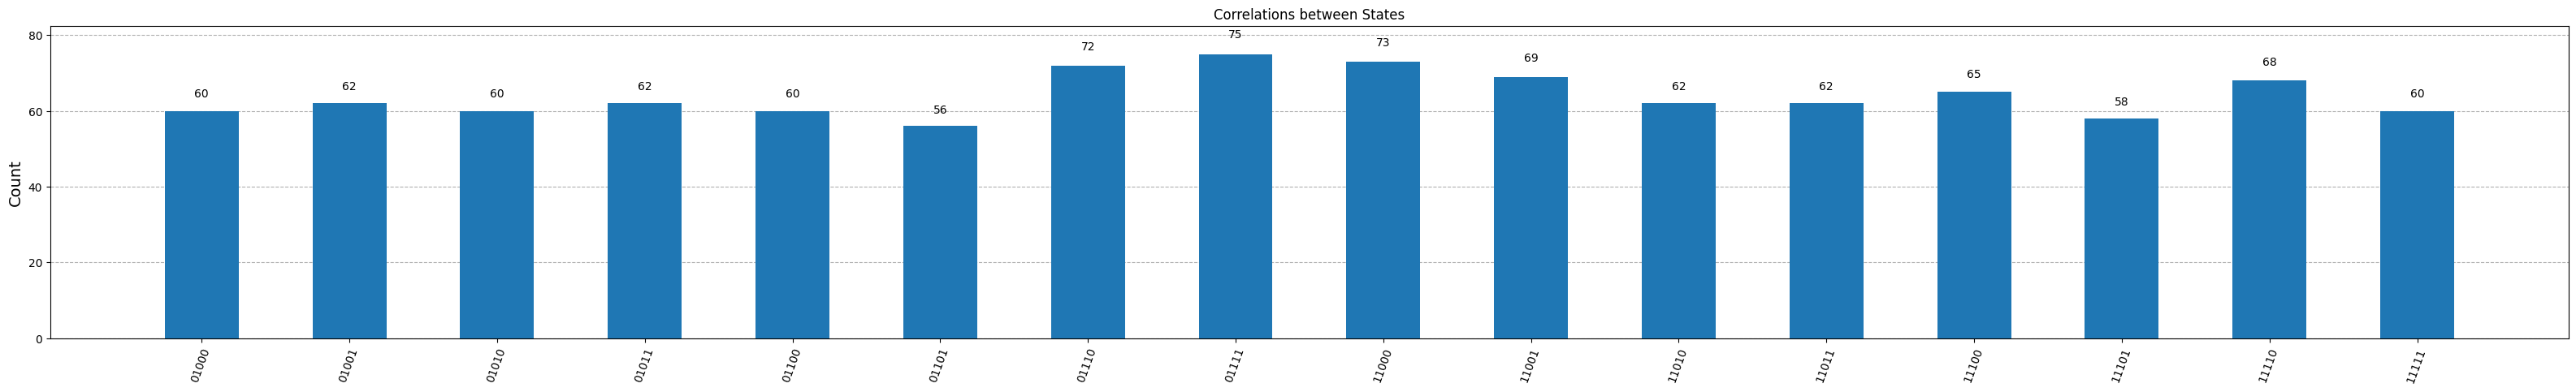

In [6]:
# find if there is any correlations between states (on simulators)
simulator = aer.AerSimulator()
transpiled_circuit = transpile(measurement_quantum_circuit,simulator)

result = simulator.run(transpiled_circuit).result()
counts = result.get_counts(transpiled_circuit)
plot_histogram(counts, title='Correlations between States',figsize=(40,5))

# Run on IBM Quantum Hardware

In [7]:
# finding correlations on IBM quantum computers
backend_name = 'ibm_brisbane'
backend      = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level = 1, backend = backend)
transpiled_circuit_quantum = pass_manager.run(measurement_quantum_circuit)




In [8]:
quantum_sampler_1_options = SamplerOptions()
quantum_simulator_1 = Sampler(backend=backend)
job = quantum_simulator_1.run([transpiled_circuit_quantum])
job_id = job.job_id()
print(job_id)

cd12b240-8167-47ef-9d21-82e0c82aab99
